# Synthetic Moho Model from Uieda et al. 2017.

Here we attempt to reproduce the simple synthetic Moho inversion from [Uieda et al. 2017:](https://doi.org/10.1093/gji/ggw390) Fast nonlinear gravity inversion in spherical coordinates with application to the South American Moho. They provide functions for creating synthetic Moho topography, which we forward model to create the observed gravity data to use for the inversion.

In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import scipy as sp
import verde as vd
from polartoolkit import maps
from polartoolkit import utils as polar_utils
import boule as bl
import pygmt
import xarray as xr

import invert4geom

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

/home/sungw937/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Recreate synthetic topography 
Here we recreate the synthetic topography model from the paper.

In [2]:
def gaussian2d(x, y, sigma_x, sigma_y, x0=0, y0=0, angle=0.0):
    """
    Taken from https://legacy.fatiando.org/api/utils.html#fatiando.utils.gaussian2d
    which is used in Uieda et al. 2017 paper.
    """
    theta = -1 * angle * np.pi / 180.0
    tmpx = 1.0 / sigma_x**2
    tmpy = 1.0 / sigma_y**2
    sintheta = np.sin(theta)
    costheta = np.cos(theta)
    a = tmpx * costheta + tmpy * sintheta**2
    b = (tmpy - tmpx) * costheta * sintheta
    c = tmpx * sintheta**2 + tmpy * costheta**2
    xhat = x - x0
    yhat = y - y0
    return np.exp(-(a * xhat**2 + 2.0 * b * xhat * yhat + c * yhat**2))

In [3]:
# Make a regular grid inside an area.
# Grid points will be the center of the top of each tesseroid in the model
shape = (40, 50)  # n, e
region_ll = (-50, 50, 10, 70)  # e, n
lon, lat = vd.grid_coordinates(region=region_ll, shape=shape)

relief = (
    -30e3
    + 15e3 * sp.special.erf((lon - 10) / 20)
    - 10e3 * gaussian2d(lat, lon, 10, 15, x0=25, y0=-30)
    + 10e3 * gaussian2d(lat, lon, 15, 20, x0=53, y0=-25)
    - 10e3 * gaussian2d(lat, lon, 3, 3, x0=50, y0=30)
    - 10e3 * gaussian2d(lat, lon, 10, 10, x0=30, y0=25) ** 2
    + 5e3 * gaussian2d(lat, lon, 40, 3, x0=40, y0=40, angle=15)
)

true_moho = vd.make_xarray_grid(
    (lon, lat),
    relief,
    dims=("latitude", "longitude"),
    data_names="upward",
)

In [4]:
# get the coordinates of the grid
_longitude, latitude = np.meshgrid(true_moho.longitude, true_moho.latitude)

# compute the geocentric radius at each latitude
geocentric_radius = bl.WGS84.geocentric_radius(latitude)

# add geocentric radius to the xarray dataset
true_moho = true_moho.assign(
    geocentric_radius=(("latitude", "longitude"), geocentric_radius)
)
true_moho

<xarray.Dataset> Size: 33kB
Dimensions:            (latitude: 40, longitude: 50)
Coordinates:
  * latitude           (latitude) float64 320B 10.0 11.54 13.08 ... 68.46 70.0
  * longitude          (longitude) float64 400B -50.0 -47.96 ... 47.96 50.0
Data variables:
    upward             (latitude, longitude) float64 16kB -4.518e+04 ... -1.3...
    geocentric_radius  (latitude, longitude) float64 16kB 6.377e+06 ... 6.359...

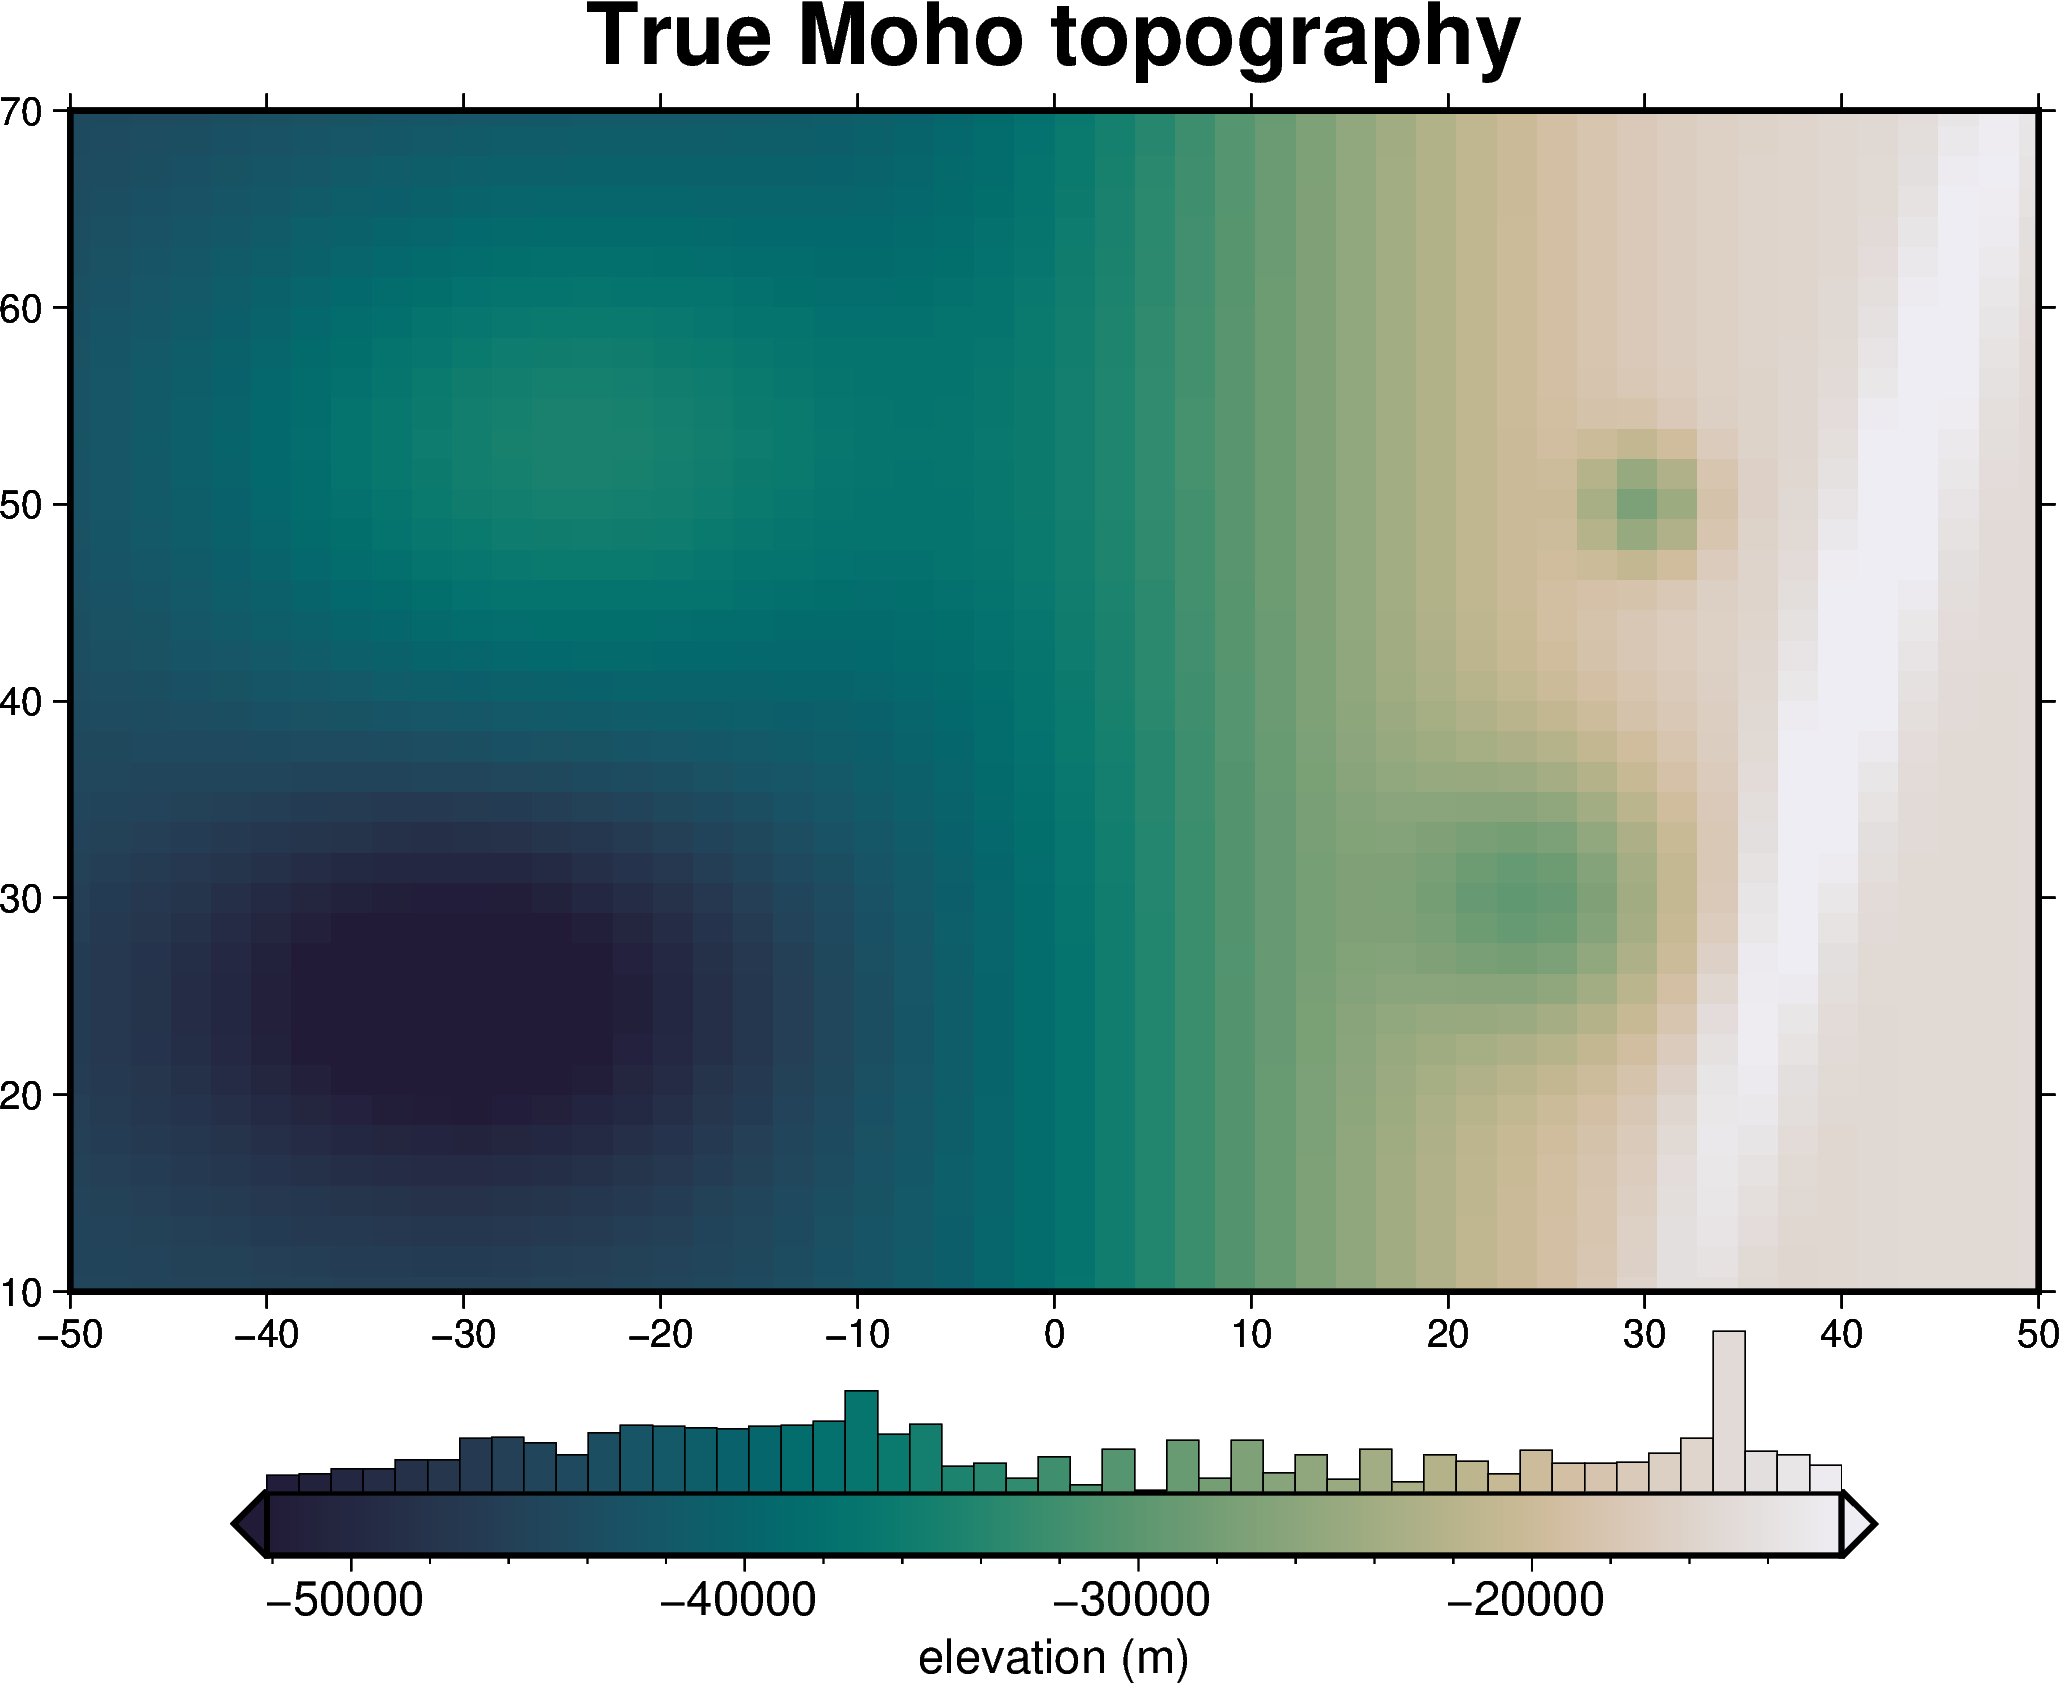

In [5]:
fig = maps.plot_grd(
    true_moho.upward,
    fig_height=10,
    title="True Moho topography",
    hist=True,
    cmap="rain",
    reverse_cpt=True,
    cbar_label="elevation (m)",
    robust=True,
    frame=["nSWe", "xaf10000", "yaf10000"],
)
fig.show()

## Observed gravity data
We can know forward-model the effects of this topography and add some noise to make a synthetic observed gravity dataset.

In [6]:
# Define the reference level (height in meters).
# This is the Moho depth of the Normal Earth
true_zref = -30e3

# The density contrast is negative if the relief is below the reference
true_density_contrast = 400

# make tesseroid layer
true_model = invert4geom.create_model(
    zref=true_zref,
    density_contrast=true_density_contrast,
    topography=true_moho,
    model_type="tesseroids",
)
true_model

<xarray.Dataset> Size: 161kB
Dimensions:                (latitude: 40, longitude: 50)
Coordinates:
  * latitude               (latitude) float64 320B 10.0 11.54 ... 68.46 70.0
  * longitude              (longitude) float64 400B -50.0 -47.96 ... 47.96 50.0
    top                    (latitude, longitude) float64 16kB 6.347e+06 ... 6...
    bottom                 (latitude, longitude) float64 16kB 6.332e+06 ... 6...
Data variables:
    density                (latitude, longitude) int64 16kB -400 -400 ... 400
    thickness              (latitude, longitude) float64 16kB 1.518e+04 ... 1...
    starting_topography    (latitude, longitude) float64 16kB 6.332e+06 ... 6...
    topography             (latitude, longitude) float64 16kB 6.332e+06 ... 6...
    mask                   (latitude, longitude) float64 16kB 1.0 1.0 ... 1.0
    geocentric_radius      (latitude, longitude) float64 16kB 6.377e+06 ... 6...
    upper_confining_layer  (latitude, longitude) float64 16kB nan nan ... nan
    lower_confining_layer  (latitude, longitude) float64 16kB nan nan ... nan
Attributes:
    inner_region:      (-50.0, 50.0, 10.0, 70.0)
    zref:              -30000.0
    density_contrast:  400
    region:            (-50.0, 50.0, 10.0, 70.0)
    spacing:           1.53846153846
    dataset_type:      model
    model_type:        tesseroids
    coord_names:       ('longitude', 'latitude')

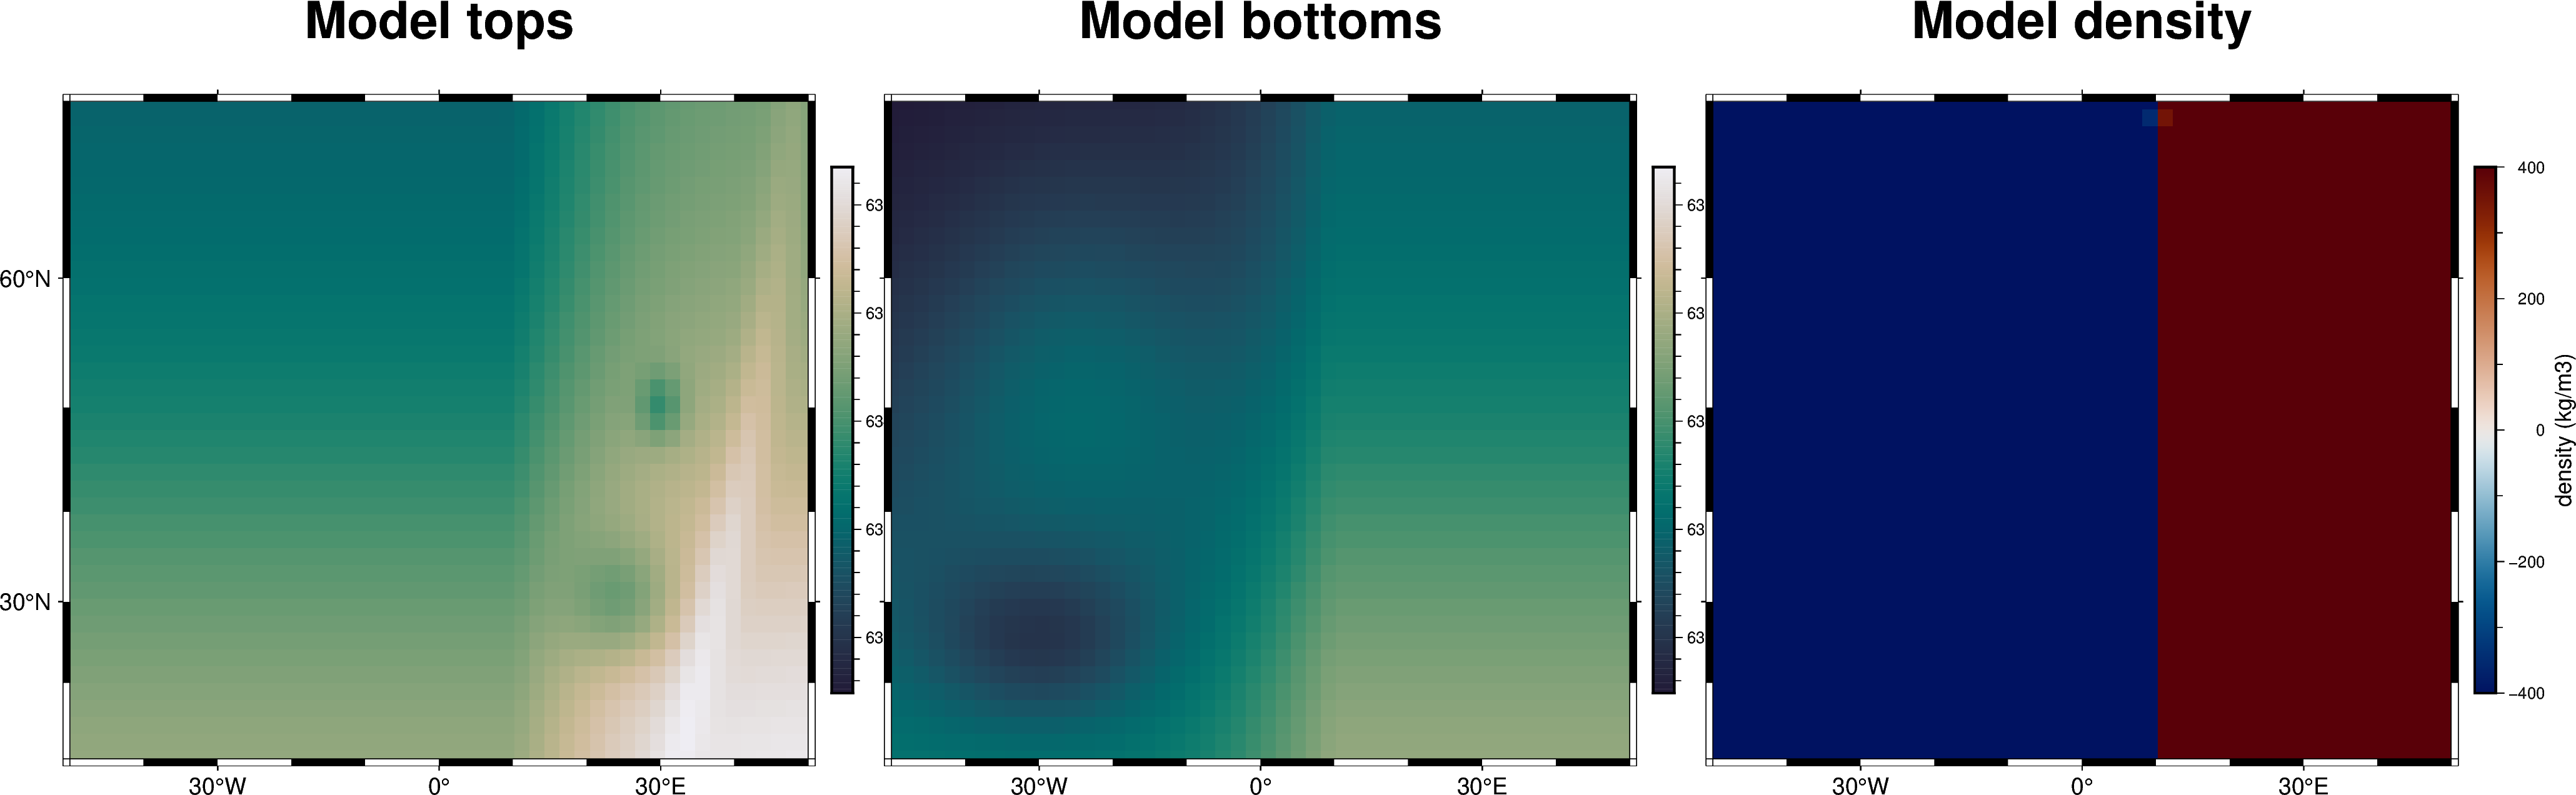

In [7]:
fig = pygmt.Figure()
proj = "M10c"

# plot tesseroid tops
pygmt.makecpt(
    cmap="rain",
    reverse=True,
    series=(polar_utils.get_combined_min_max((true_model.top, true_model.bottom))),
    background=True,
)
fig.grdimage(true_model.top, projection=proj, frame=["neSW+tModel tops", "af"])
fig.colorbar(frame="af+lelevation (m)", position="JCR")

fig.shift_origin(xshift="w+4c")

# plot tesseroid bottoms
fig.grdimage(true_model.bottom, projection=proj, frame=["neSw+tModel bottoms", "af"])
fig.colorbar(frame="af+lelevation (m)", position="JCR")

fig.shift_origin(xshift="w+4c")

# # plot tesseroid densities
pygmt.makecpt(
    cmap="vik",
    background=True,
    series=polar_utils.get_min_max(true_model.density),
)
fig.grdimage(true_model.density, projection=proj, frame=["neSw+tModel density", "af"])
fig.colorbar(frame="af+ldensity (kg/m3)", position="JCR")

fig.show()

In [8]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=true_model.region,
    spacing=true_model.spacing,
    pixel_register=False,
    extra_coords=50e3,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("latitude", "longitude"),
)


# get the coordinates of the grid
_longitude, latitude = np.meshgrid(observations.longitude, observations.latitude)

# compute the geocentric radius at each latitude
geocentric_radius = bl.WGS84.geocentric_radius(latitude)

# add geocentric radius to the xarray dataset
observations = observations.assign(
    geocentric_radius=(("latitude", "longitude"), geocentric_radius)
)

grav_data = invert4geom.create_data(
    observations,
    model_type="tesseroids",
)

grav_data.inv.forward_gravity(true_model, "gravity_anomaly")

# contaminate gravity with random noise
grav_data["gravity_anomaly"], stddev = invert4geom.contaminate(
    grav_data.gravity_anomaly,
    stddev=5,
    percent=False,
    seed=0,
)

grav_data

<xarray.Dataset> Size: 64kB
Dimensions:            (latitude: 40, longitude: 66)
Coordinates:
  * latitude           (latitude) float64 320B 10.0 11.54 13.08 ... 68.46 70.0
  * longitude          (longitude) float64 528B -50.0 -48.46 ... 48.46 50.0
Data variables:
    upward             (latitude, longitude) float64 21kB 6.427e+06 ... 6.409...
    geocentric_radius  (latitude, longitude) float64 21kB 6.377e+06 ... 6.359...
    gravity_anomaly    (latitude, longitude) float64 21kB -177.5 ... 151.6
Attributes:
    region:        (-50.0, 50.0, 10.0, 70.0)
    spacing:       1.53846153846
    buffer_width:  6.15384615384
    inner_region:  (-43.84615384616, 43.84615384616, 16.15384615384, 63.84615...
    dataset_type:  data
    model_type:    tesseroids
    coord_names:   ('longitude', 'latitude')

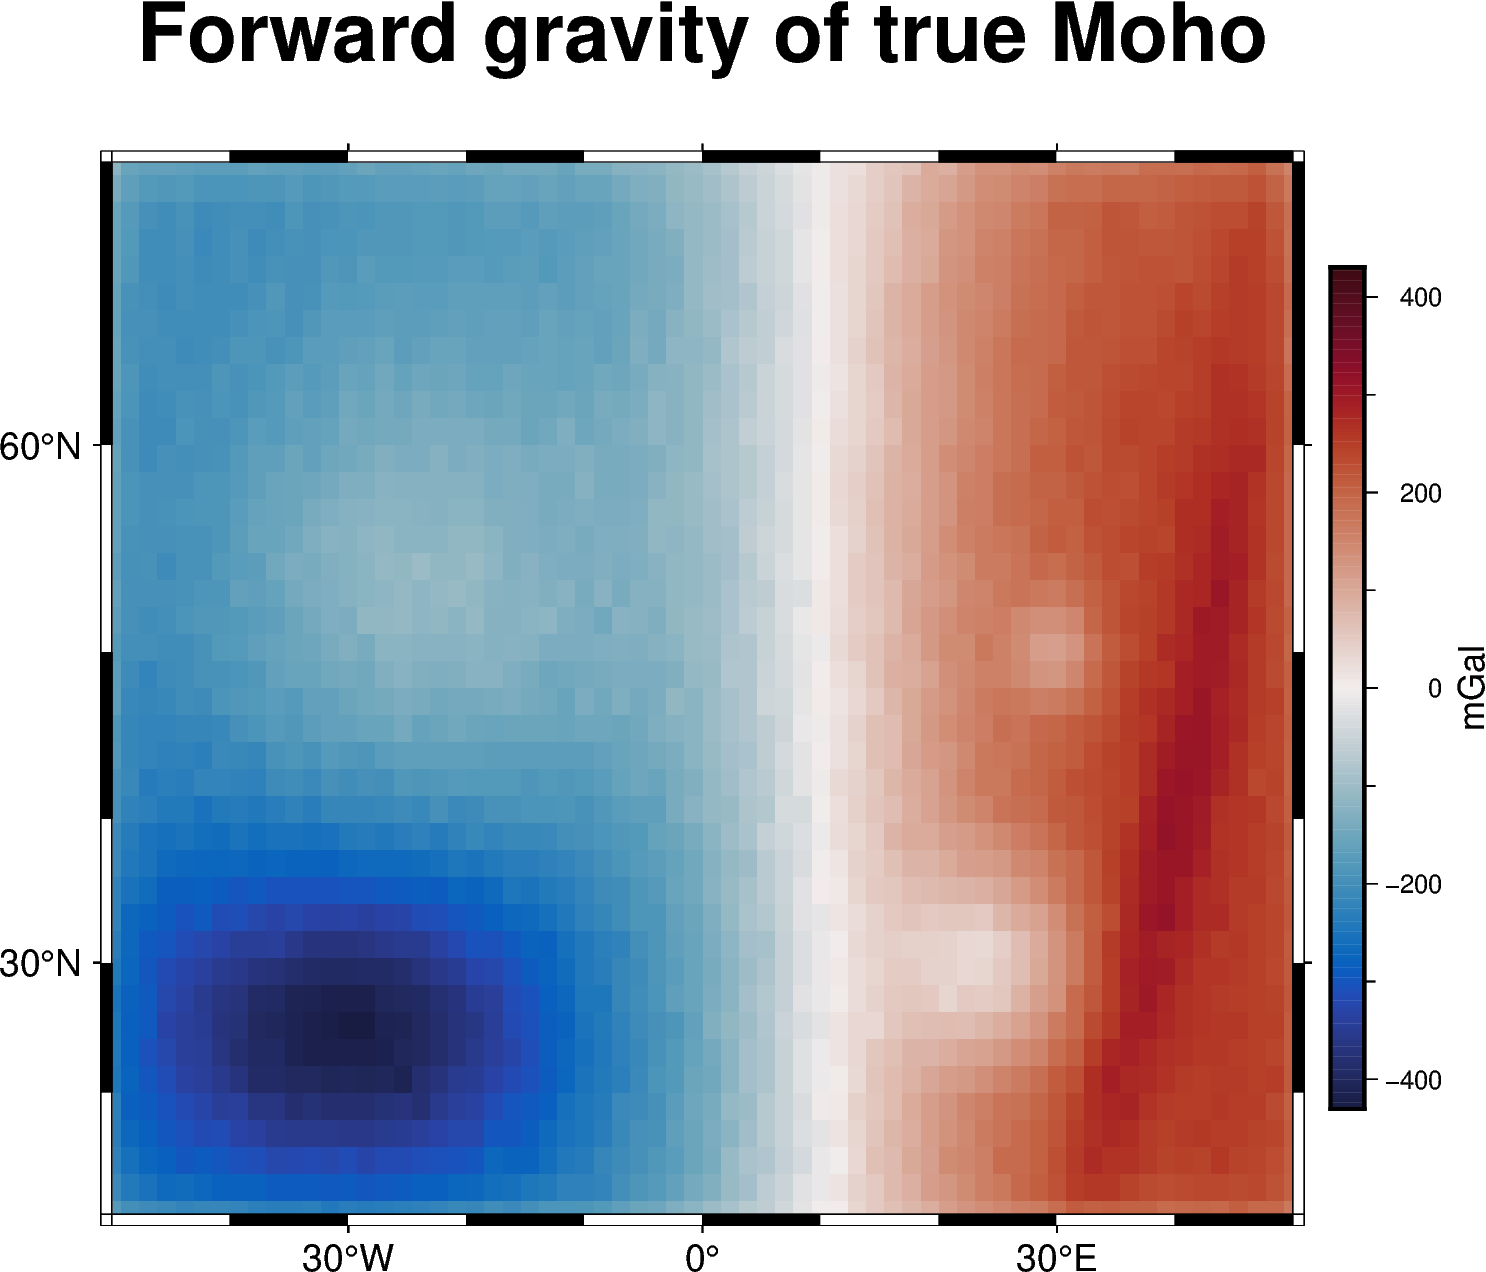

In [9]:
fig = pygmt.Figure()
proj = "M10c"
# plot observed gravity
pygmt.makecpt(
    cmap="balance+h0",
    series=polar_utils.get_min_max(grav_data.gravity_anomaly, absolute=True),
    background=True,
)
fig.grdimage(
    grav_data.gravity_anomaly,
    projection=proj,
    frame=["neSW+tForward gravity of true Moho", "af"],
)
fig.colorbar(frame="af+lmGal", position="JCR")
fig.show()

## Starting model
Following the paper's approach, we create a starting model which uses the true values of the density contrast and reference level for the Moho, but with a depth of 60 km. This is used during the damping parameter cross-validation.

In [10]:
# create flat topography grid with a constant height of -60 km
starting_topography = xr.full_like(true_moho.upward, -60e3).to_dataset(
    name="upward"
)

# add geocentric radius to the xarray dataset
starting_topography["geocentric_radius"] = true_moho.geocentric_radius

# convert topography into tesseroid model
model = invert4geom.create_model(
    zref=true_zref,
    density_contrast=true_density_contrast,
    topography=starting_topography,
    model_type="tesseroids",
)
model

<xarray.Dataset> Size: 161kB
Dimensions:                (latitude: 40, longitude: 50)
Coordinates:
  * latitude               (latitude) float64 320B 10.0 11.54 ... 68.46 70.0
  * longitude              (longitude) float64 400B -50.0 -47.96 ... 47.96 50.0
    top                    (latitude, longitude) float64 16kB 6.347e+06 ... 6...
    bottom                 (latitude, longitude) float64 16kB 6.317e+06 ... 6...
Data variables:
    density                (latitude, longitude) int64 16kB -400 -400 ... -400
    thickness              (latitude, longitude) float64 16kB 3e+04 ... 3e+04
    starting_topography    (latitude, longitude) float64 16kB 6.317e+06 ... 6...
    topography             (latitude, longitude) float64 16kB 6.317e+06 ... 6...
    mask                   (latitude, longitude) float64 16kB 1.0 1.0 ... 1.0
    geocentric_radius      (latitude, longitude) float64 16kB 6.377e+06 ... 6...
    upper_confining_layer  (latitude, longitude) float64 16kB nan nan ... nan
    lower_confining_layer  (latitude, longitude) float64 16kB nan nan ... nan
Attributes:
    inner_region:      (-50.0, 50.0, 10.0, 70.0)
    zref:              -30000.0
    density_contrast:  400
    region:            (-50.0, 50.0, 10.0, 70.0)
    spacing:           1.53846153846
    dataset_type:      model
    model_type:        tesseroids
    coord_names:       ('longitude', 'latitude')

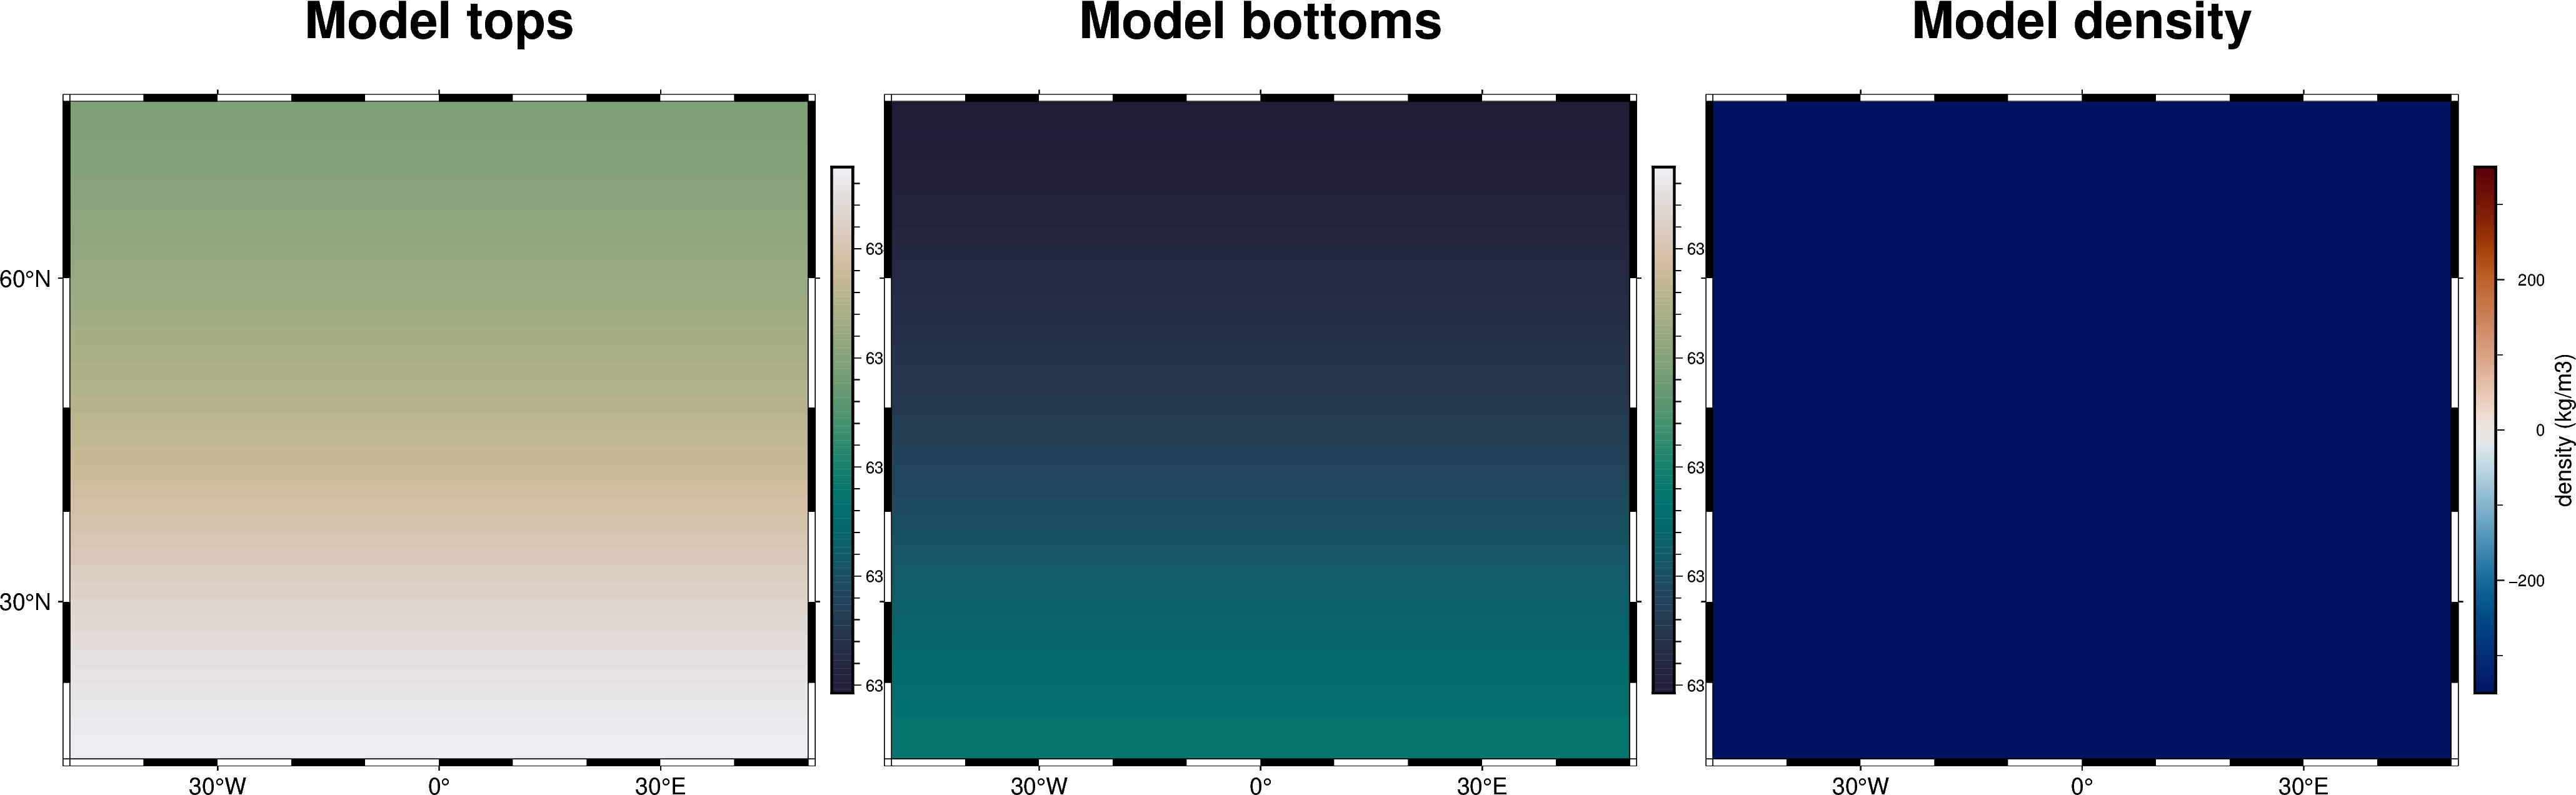

In [11]:
fig = pygmt.Figure()
proj = "M10c"

# plot tesseroid tops
pygmt.makecpt(
    cmap="rain",
    reverse=True,
    series=(polar_utils.get_combined_min_max((model.top, model.bottom))),
    background=True,
)
fig.grdimage(model.top, projection=proj, frame=["neSW+tModel tops", "af"])
fig.colorbar(frame="af+lelevation (m)", position="JCR")

fig.shift_origin(xshift="w+4c")

# plot tesseroid bottoms
fig.grdimage(model.bottom, projection=proj, frame=["neSw+tModel bottoms", "af"])
fig.colorbar(frame="af+lelevation (m)", position="JCR")

fig.shift_origin(xshift="w+4c")

# # plot tesseroid densities
pygmt.makecpt(
    cmap="vik+h0",
    background=True,
    series=[-350, 350],
)
fig.grdimage(model.density, projection=proj, frame=["neSw+tModel density", "af"])
fig.colorbar(frame="af+ldensity (kg/m3)", position="JCR")

fig.show()

In [12]:
# calculate the forward gravity of the initial model
grav_data.inv.forward_gravity(
    model,
    progressbar=True,
)

  0%|          | 0/2640 [00:00<?, ?it/s]

In [13]:
# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and set
# it to 0
grav_data.inv.regional_separation(
    method="constant",
    constant=0,
)
grav_data.inv.df

,latitude,longitude,upward,geocentric_radius,gravity_anomaly,forward_gravity,misfit,reg,res,starting_forward_gravity,starting_misfit,starting_reg,starting_res
0,10.0,-50.000000,6.427497e+06,6.377497e+06,-177.539485,-373.983967,196.444482,0.0,196.444482,-373.983967,196.444482,0.0,196.444482
1,10.0,-48.461538,6.427497e+06,6.377497e+06,-201.635497,-418.831128,217.195631,0.0,217.195631,-418.831128,217.195631,0.0,217.195631
2,10.0,-46.923077,6.427497e+06,6.377497e+06,-205.519436,-433.090182,227.570746,0.0,227.570746,-433.090182,227.570746,0.0,227.570746
3,10.0,-45.384615,6.427497e+06,6.377497e+06,-212.839722,-440.629012,227.789290,0.0,227.789290,-440.629012,227.789290,0.0,227.789290
4,10.0,-43.846154,6.427497e+06,6.377497e+06,-219.639252,-445.621901,225.982649,0.0,225.982649,-445.621901,225.982649,0.0,225.982649
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,70.0,43.846154,6.409272e+06,6.359272e+06,188.732251,-439.099136,627.831388,0.0,627.831388,-439.099136,627.831388,0.0,627.831388
2636,70.0,45.384615,6.409272e+06,6.359272e+06,193.728614,-428.896860,622.625475,0.0,622.625475,-428.896860,622.625475,0.0,622.625475
2637,70.0,46.923077,6.409272e+06,6.359272e+06,206.110610,-412.781715,618.892325,0.0,618.892325,-412.781715,618.892325,0.0,618.892325
2638,70.0,48.461538,6.409272e+06,6.359272e+06,179.914244,-384.278184,564.192427,0.0,564.192427,-384.278184,564.192427,0.0,564.192427


In [14]:
# setup the inversion
inv = invert4geom.Inversion(
    grav_data,
    model,
    deriv_type="finite_difference",
    # set stopping criteria
    max_iterations=30,
    l2_norm_tolerance=2.2,  # gravity error is 5 mGal or L2-norm of ~2.2
    delta_l2_norm_tolerance=1.001,
)

In [15]:
# resample data at 1/2 spacing to include test points for cross-validation
inv.data = invert4geom.add_test_points(inv.data)
inv.data.inv.df

,latitude,longitude,test,upward,geocentric_radius,gravity_anomaly,forward_gravity,misfit,reg,res,starting_forward_gravity,starting_misfit,starting_reg,starting_res
0,10.0,-50.000000,False,6427497.5,6377497.5,-177.539490,-373.983978,196.444489,0.0,196.444489,-373.983978,196.444489,0.0,196.444489
1,10.0,-49.230769,True,6427497.5,6377497.5,-190.850748,-398.319302,207.468563,0.0,207.468563,-398.319302,207.468563,0.0,207.468563
2,10.0,-48.461538,False,6427497.5,6377497.5,-201.635498,-418.831116,217.195633,0.0,217.195633,-418.831116,217.195633,0.0,217.195633
3,10.0,-47.692308,True,6427497.5,6377497.5,-204.625952,-428.292418,223.666473,0.0,223.666473,-428.292418,223.666473,0.0,223.666473
4,10.0,-46.923077,False,6427497.5,6377497.5,-205.519440,-433.090179,227.570740,0.0,227.570740,-433.090179,227.570740,0.0,227.570740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10344,70.0,46.923077,False,6409272.5,6359272.5,206.110611,-412.781708,618.892334,0.0,618.892334,-412.781708,618.892334,0.0,618.892334
10345,70.0,47.692308,True,6409272.5,6359272.5,195.554620,-400.901731,596.456358,0.0,596.456358,-400.901731,596.456358,0.0,596.456358
10346,70.0,48.461538,False,6409272.5,6359272.5,179.914246,-384.278198,564.192444,0.0,564.192444,-384.278198,564.192444,0.0,564.192444
10347,70.0,49.230769,True,6409272.5,6359272.5,165.898759,-358.843904,524.742662,0.0,524.742662,-358.843904,524.742662,0.0,524.742662


## Damping parameter cross validation

  0%|          | 0/4 [00:00<?, ?it/s]

Inversion terminated due to max_iterations limit. Consider increasing this limit.


  0%|          | 0/4 [00:00<?, ?it/s]

0.0009899400604038676

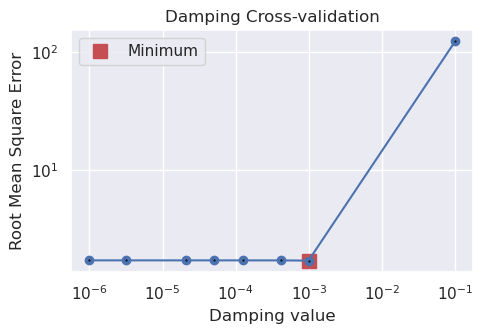

In [16]:
damping_cv_obj = inv.optimize_inversion_damping(
    damping_limits=(1e-6, 1e-1),
    n_trials=8,
    plot_scores=True,
    fname="../tmp/uieda_synthetic_damping_CV",
)
inv.solver_damping

The above plot shows the results of the damping parameter cross validation, and is equivalent to Figure 5e in the paper. The main difference is that we use a optimization approach instead of a grid search. This allows us to find the best value in fewer trials, as the parameter search space is quickly narrowed down. We performed 8 trials, compared to the 16 trials used in the paper.

In [17]:
damping_cv_obj.study.trials_dataframe().sort_values("value")

,number,value,datetime_start,datetime_complete,duration,params_damping,user_attrs_fname,system_attrs_fixed_params,state
3,3,1.695880,2026-01-19 13:58:51.505983,2026-01-19 13:59:14.887826,0 days 00:00:23.381843,0.000990,../tmp/uieda_synthetic_damping_CV_trial_3,NaN,COMPLETE
5,5,1.702090,2026-01-19 13:59:38.473803,2026-01-19 13:59:57.584074,0 days 00:00:19.110271,0.000414,../tmp/uieda_synthetic_damping_CV_trial_5,NaN,COMPLETE
4,4,1.702993,2026-01-19 13:59:14.922560,2026-01-19 13:59:38.472510,0 days 00:00:23.549950,0.000126,../tmp/uieda_synthetic_damping_CV_trial_4,NaN,COMPLETE
7,7,1.703059,2026-01-19 14:00:33.953534,2026-01-19 14:01:05.479861,0 days 00:00:31.526327,0.000051,../tmp/uieda_synthetic_damping_CV_trial_7,NaN,COMPLETE
6,6,1.703070,2026-01-19 13:59:57.585566,2026-01-19 14:00:33.943221,0 days 00:00:36.357655,0.000021,../tmp/uieda_synthetic_damping_CV_trial_6,NaN,COMPLETE
2,2,1.703072,2026-01-19 13:58:29.889907,2026-01-19 13:58:51.504199,0 days 00:00:21.614292,0.000003,../tmp/uieda_synthetic_damping_CV_trial_2,NaN,COMPLETE
0,0,1.703072,2026-01-19 13:52:00.123480,2026-01-19 13:52:39.382900,0 days 00:00:39.259420,0.000001,../tmp/uieda_synthetic_damping_CV_trial_0,{'damping': 1e-06},COMPLETE
1,1,124.288622,2026-01-19 13:52:39.384383,2026-01-19 13:58:29.885388,0 days 00:05:50.501005,0.100000,../tmp/uieda_synthetic_damping_CV_trial_1,{'damping': 0.1},COMPLETE


## Inversion results

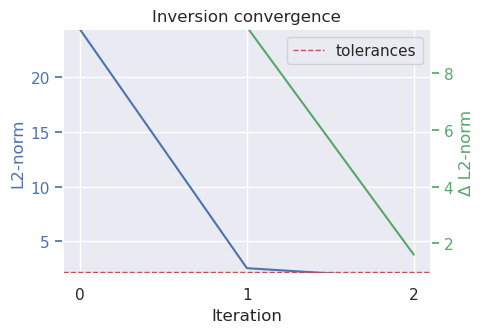

In [20]:
inv.plot_convergence()

The top plot above compares gravity misfit before and after the inversion. The right subplot is equivalent to Figure 5c in the paper. 

The lower plot shows the iteration results of the inversion, and has all the parameter values and metadata at the top. From this, you can see the inversion terminated after 2 iterations due to the inversion reaching the set L2-norm tolerance. 

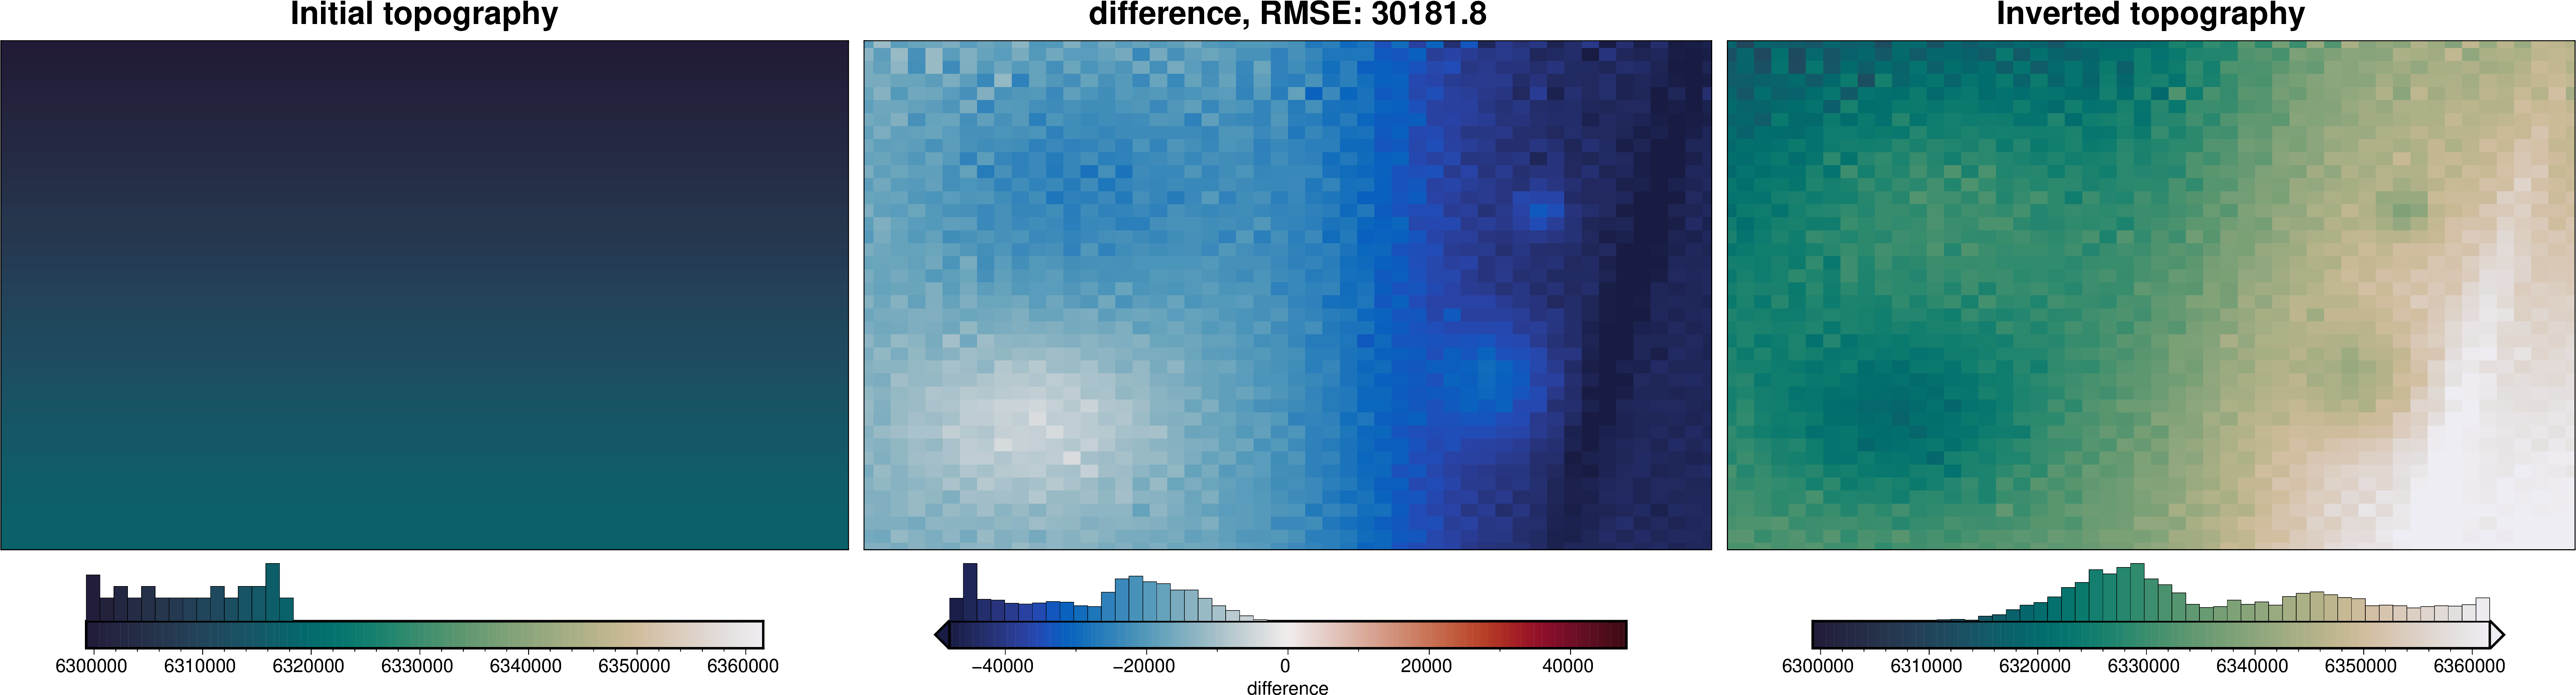

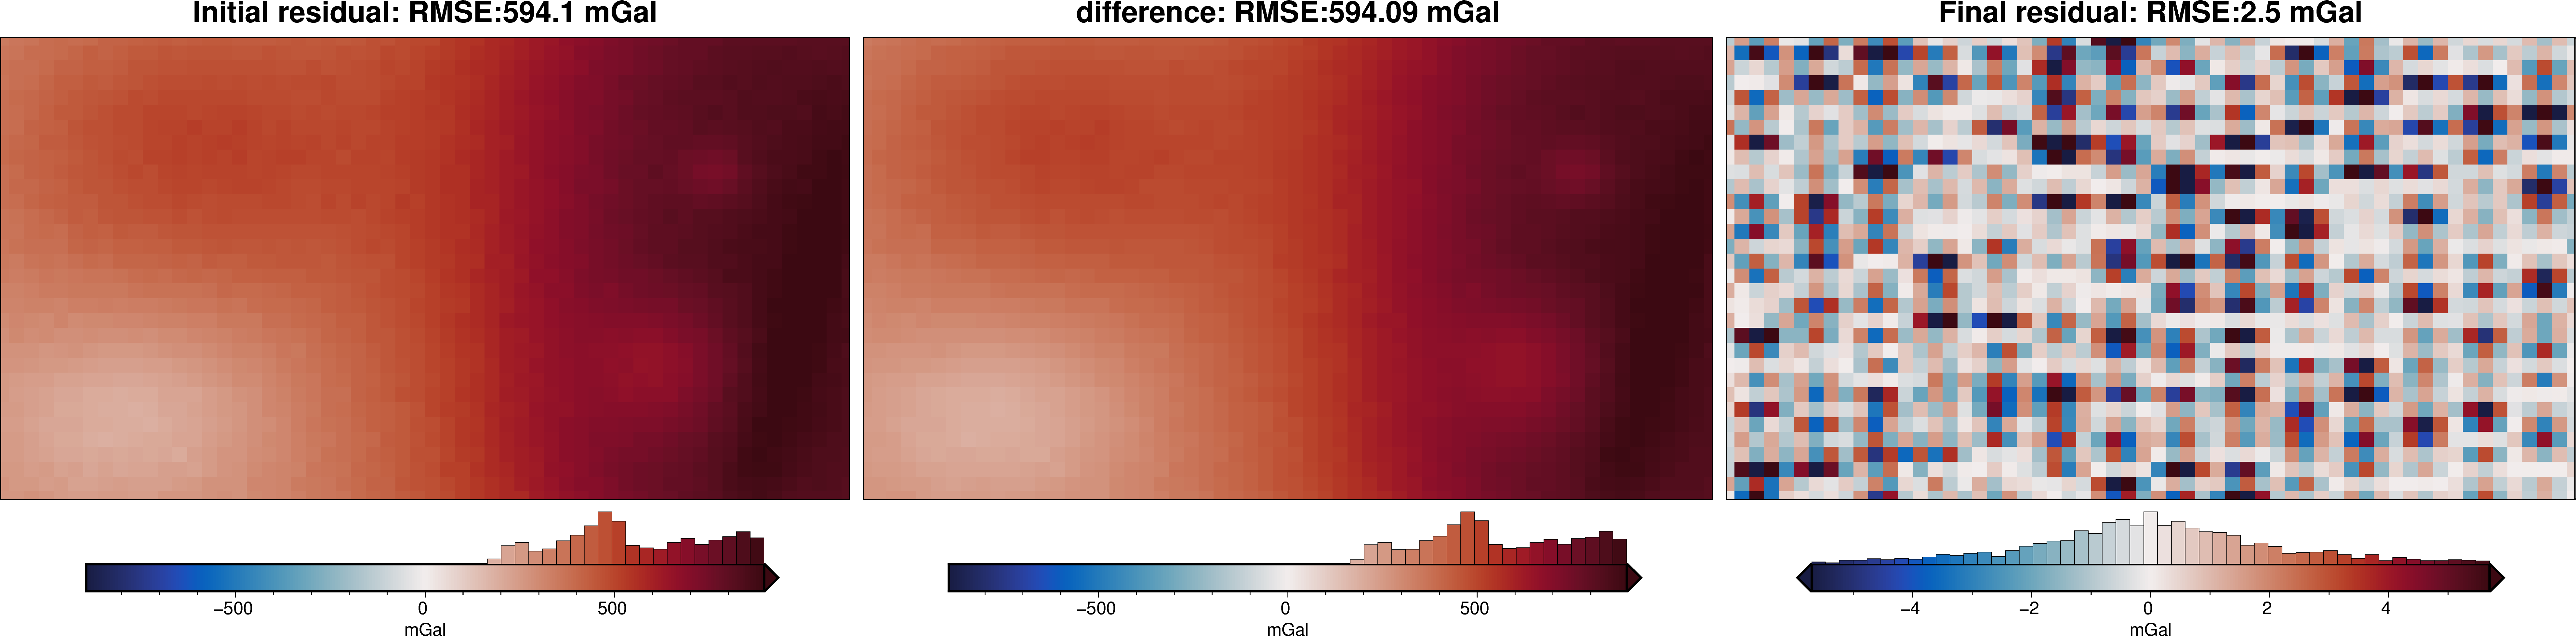

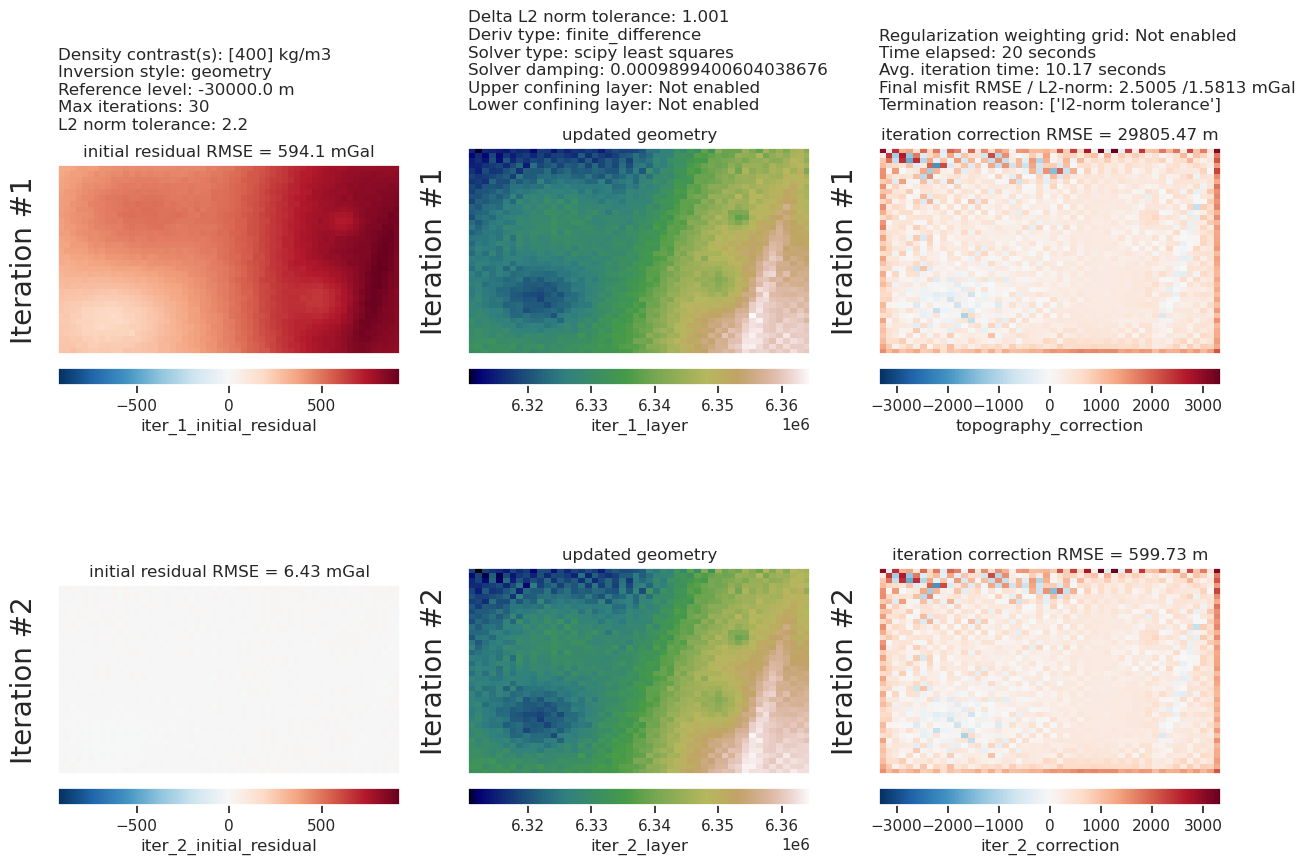

In [ ]:
inv.plot_inversion_results(
    iters_to_plot=2,
)
SEPARATE OUT THESE PLOTS!

## Compare inverted with true topography
The plot below shows how the inversion performed. In the title, you can see the root mean squared difference (RMSE) between the true moho topography and the inversion topography, and the colorbar histogram shows the distribution of the differences. 

The errors appear to be normally distributed around 0, with max and min values of around 7km. Uieda et al. 2017 reported max and min errors of 2.19 and 2.13 km, showing the similar effectiveness of these two inversions. The middle plot below is equivalent to the paper's Figure 5b.

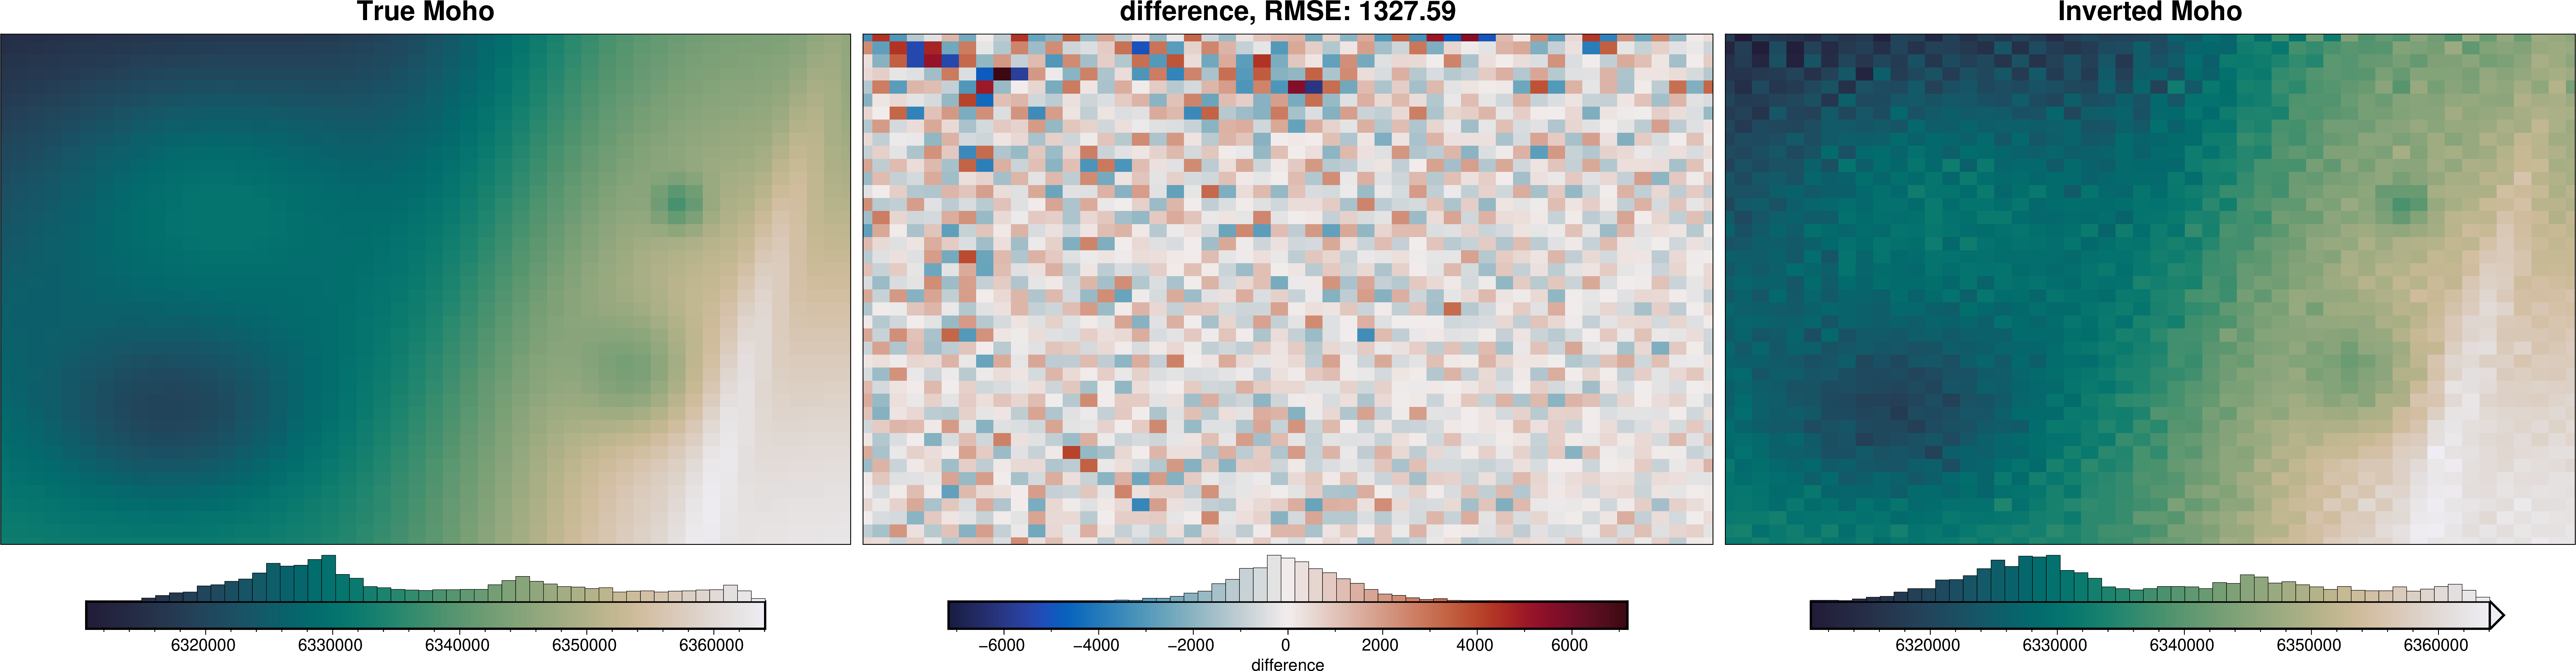

In [19]:
_ = polar_utils.grd_compare(
    true_moho.upward + true_moho.geocentric_radius,
    inv.model.topography,
    grid1_name="True Moho",
    grid2_name="Inverted Moho",
    hist=True,
    inset=False,
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
)